<a href="https://colab.research.google.com/github/alliwene/msc-project/blob/main/msc_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Plant Leaf Disease Detection Using FastAI

In [ ]:
# Mount Google Drive
from google.colab import drive # import drive from google colab
import os, random 
ROOT = "/content/drive"     # default location for the drive

drive.mount(ROOT)  

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# set file path
path = "/content/drive/My Drive/PlantVillage-Dataset/raw/color"
os.chdir(path)
!ls

Exp  models  test  train


In [ ]:
# %reload_ext autoreload
# %autoreload 2
%matplotlib inline

In [ ]:
!pip install --quiet pretrainedmodels
# !pip install --upgrade git+https://github.com/fastai/fastai.git
# !pip install "torch==1.4" "torchvision==0.5.0"

     |████████████████████████████████| 61kB 5.9MB/s 


In [ ]:
import  os
import warnings
warnings.filterwarnings("ignore")

# import fastai library
import fastai
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from fastai.metrics import error_rate, accuracy

from PIL import Image
from sklearn.utils import shuffle
from random import shuffle

import seaborn as sns
sns.set()

In [ ]:
plt.rcParams['figure.figsize'] = [16, 10]
plt.rcParams['font.size'] = 16

sns.set_palette('muted',color_codes=True)
sns.set_context('notebook', font_scale=1.4)
vc_color = '#B5C9EB'

In [ ]:
# set seed to reproduce same results 
def seed_everything(seed):
  random.seed(seed)
  # os.environ['PYTHONHASHSEED'] == str(seed)
  np.random.seed(seed)
  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.deterministic = True

seed_everything(200)

## Exploratory Data Analysis

In [ ]:
import pandas as pd

# get labels and number of images in each label
labels = os.listdir("train")

res =  []
for label in labels:
    file_len = len(os.listdir("train/"+label))
    res.append([label,file_len])
    

df = pd.DataFrame(res, columns=['class','class_count'])  
df.head()

class  class_count
0        Apple___Apple_scab         1070
1         Apple___Black_rot         1042
2  Apple___Cedar_apple_rust          792
3           Apple___healthy         1505
4       Blueberry___healthy         1402

In [ ]:
d2 = [int(item[1]) for item in res]
print(f"Total number of images: {sum(d2)}")

Total number of images: 42754


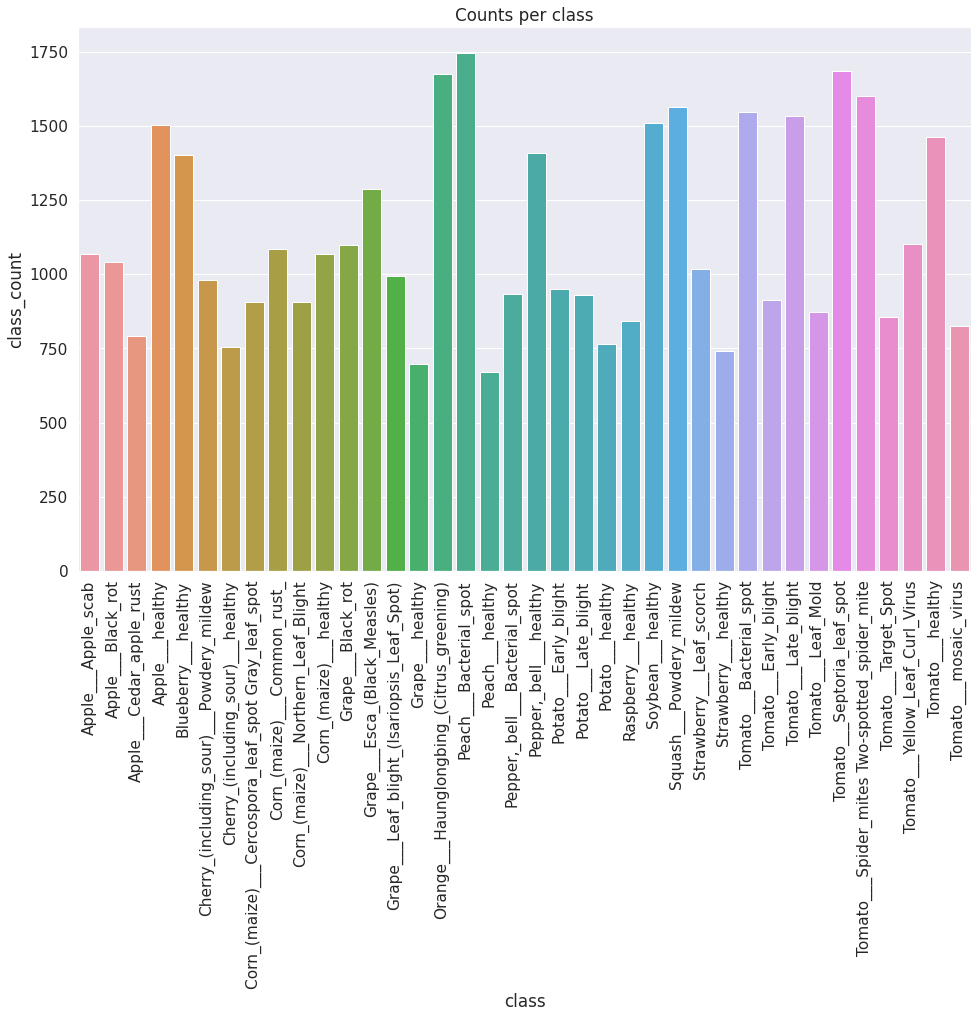

In [ ]:
# plot class count for all labels 
ax = sns.barplot('class', 'class_count', data=df)
for item in ax.get_xticklabels():
    item.set_rotation(90)

ax.set_title('Counts per class')
plt.savefig('count_per_class.png');

In [ ]:
# List of species
species = set()
for c in labels:
    s = re.findall(r"(.+)___(.+)", c)
    for p in s:
      species.add(p[0])
print(len(species))
print(species) 

14
{'Squash', 'Potato', 'Tomato', 'Raspberry', 'Strawberry', 'Pepper,_bell', 'Corn_(maize)', 'Cherry_(including_sour)', 'Peach', 'Blueberry', 'Orange', 'Apple', 'Grape', 'Soybean'}


In [ ]:
# List of diseases
diseases = set()
for c in labels:
    s = re.findall(r"(.+)___(.+)", c)
    for p in s:
      diseases.add(p[1])
      # print(p[1])
print(len(diseases))
print(diseases)

21
{'Cercospora_leaf_spot Gray_leaf_spot', 'Apple_scab', 'Septoria_leaf_spot', 'Northern_Leaf_Blight', 'Cedar_apple_rust', 'Late_blight', 'Leaf_blight_(Isariopsis_Leaf_Spot)', 'Spider_mites Two-spotted_spider_mite', 'Leaf_Mold', 'mosaic_virus', 'Haunglongbing_(Citrus_greening)', 'Common_rust_', 'healthy', 'Leaf_scorch', 'Target_Spot', 'Powdery_mildew', 'Yellow_Leaf_Curl_Virus', 'Early_blight', 'Esca_(Black_Measles)', 'Bacterial_spot', 'Black_rot'}


In [ ]:
# Look at specie, disease combinations
combined = []
for d in diseases:
    for s in species:
        name = s + "___" + d
        if name in labels:
            out = (d, s, 1)
        else:
            out = (d, s, 0)
        combined.append(out)
combined = pd.DataFrame(combined)
combined.columns = ['disease', 'specie', 'flag']
hm = combined.pivot_table(values='flag', index='disease', columns='specie')
hm

specie                                Apple  Blueberry  ...  Strawberry  Tomato
disease                                                 ...                    
Apple_scab                                1          0  ...           0       0
Bacterial_spot                            0          0  ...           0       1
Black_rot                                 1          0  ...           0       0
Cedar_apple_rust                          1          0  ...           0       0
Cercospora_leaf_spot Gray_leaf_spot       0          0  ...           0       0
Common_rust_                              0          0  ...           0       0
Early_blight                              0          0  ...           0       1
Esca_(Black_Measles)                      0          0  ...           0       0
Haunglongbing_(Citrus_greening)           0          0  ...           0       0
Late_blight                               0          0  ...           0       1
Leaf_Mold                                 0          0  ...           0       1
Leaf_blight_(Isariopsis_Leaf_Spot)        0          0  ...           0       0
Leaf_scorch                               0          0  ...           1       0
Northern_Leaf_Blight                      0          0  ...           0       0
Powdery_mildew                            0          0  ...           0       0
Septoria_leaf_spot                        0          0  ...           0       1
Spider_mites Two-spotted_spider_mite      0          0  ...           0       1
Target_Spot                               0          0  ...           0       1
Yellow_Leaf_Curl_Virus                    0          0  ...           0       1
healthy                                   1          1  ...           1       1
mosaic_virus                              0          0  ...           0       1

[21 rows x 14 columns]

In [ ]:
data_dir = '/content/drive/My Drive/PlantVillage-Dataset/raw/color/train/'

In [ ]:
# Get path and label for each training image
db = []
for label, class_name in enumerate(labels):
    pth = data_dir + class_name
    for file in os.listdir(pth):
        if not '.ini' in file:
            db.append(['{}/{}'.format(class_name, file), label, class_name])
db = pd.DataFrame(db, columns=['file', 'label', 'class_name'])
db.head()

file  label          class_name
0  Apple___Apple_scab/352a5659-3552-4e94-8333-c37...      0  Apple___Apple_scab
1  Apple___Apple_scab/35694cb9-efe9-441a-a810-13e...      0  Apple___Apple_scab
2  Apple___Apple_scab/35fde58e-46ea-4d1b-9580-ead...      0  Apple___Apple_scab
3  Apple___Apple_scab/3636b2d7-b888-437b-b4e3-a8a...      0  Apple___Apple_scab
4  Apple___Apple_scab/3652fd23-ba4c-4958-8db8-3af...      0  Apple___Apple_scab

In [ ]:
def read_img(filepath, size):
    img = image.load_img(data_dir + filepath, target_size=size)
    img = image.img_to_array(img)
    return img

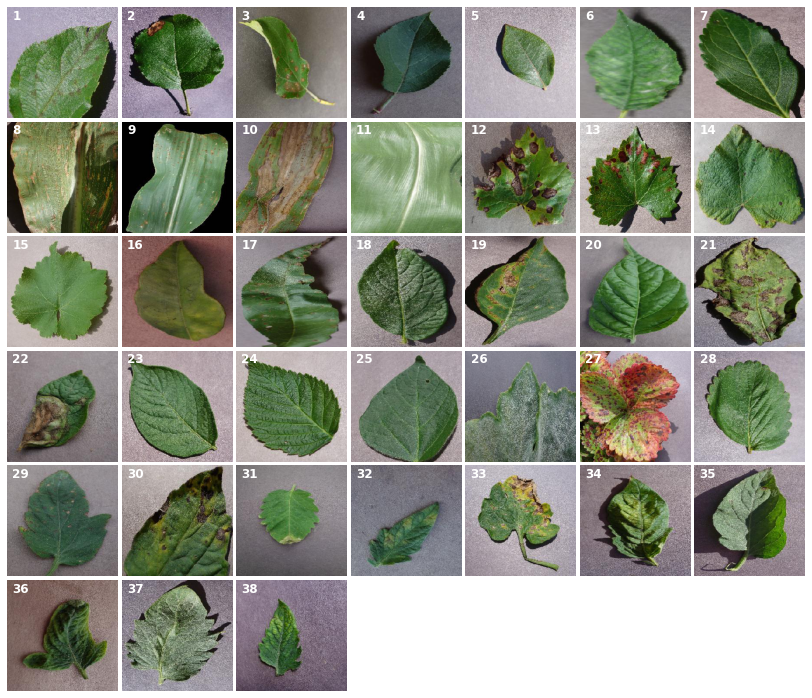

In [ ]:
from mpl_toolkits.axes_grid1 import ImageGrid
from keras.preprocessing import image

# Plot image from each class
fig = plt.figure(1, figsize=(15, 10))
grid = ImageGrid(fig, 111, nrows_ncols=(6, 7), axes_pad=0.05)

for i in range(42):
    ax = grid[i]
    ax.axis('off')
    if i < len(labels):
        class_name = labels[i]
        for filepath in db[db['class_name'] == class_name]['file'].values[:1]:
            img = read_img(filepath, (224, 224))
            ax.imshow(img / 255.)
            ax.annotate(i+1, xy=(10,25), color="white", fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig("image_per_specie.png");

## Base Model

In [ ]:
# specify home directory
path = Path(path)

In [ ]:
# specify path to train images, test images
train = path/'train'
test = path/'test'

In [ ]:
# specify training image dataframe, home directory path and train image path
tfms = get_transforms(do_flip=True, flip_vert=True, max_rotate=10.0, 
                      max_zoom=1.1, max_lighting=0.2, max_warp=0.2, 
                      p_affine=0.75, p_lighting=0.75)
image_size = 224
bs = 64

data = (ImageList.from_folder(train) 
        .split_subsets(train_size=0.5, valid_size=0.09, seed=200)
        .label_from_folder()
        .add_test_folder(test) 
        .transform(tfms, size = image_size)
        .databunch(bs=bs, num_workers=4)
        .normalize(imagenet_stats)) 
data  

ImageDataBunch;

Train: LabelList (21377 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Tomato___Early_blight,Tomato_mosaic_virus,Tomato___Septoria_leaf_spot,Tomato___Leaf_Mold,Cherry_(including_sour)___Powdery_mildew
Path: /content/drive/My Drive/PlantVillage-Dataset/raw/color/train;

Valid: LabelList (3847 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Potato___Early_blight,Orange___Haunglongbing_(Citrus_greening),Tomato___Early_blight,Raspberry___healthy,Cherry_(including_sour)___Powdery_mildew
Path: /content/drive/My Drive/PlantVillage-Dataset/raw/color/train;

Test: LabelList (3102 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: /content/drive/My Drive/PlantVillage-Dataset/raw/color/train

In [ ]:
len(data.classes)

38

In [ ]:
plt.tight_layout
data.show_batch()

In [ ]:
# set base model architecture
import torch
import torch.nn as nn
import torch.nn.functional as F

def conv_block(in_f, out_f, *args, **kwargs):
    return nn.Sequential(
        nn.Conv2d(in_f, out_f, *args, **kwargs),
        nn.ReLU(),
        nn.BatchNorm2d(out_f),
        nn.MaxPool2d(2,2)
    )

def dec_block(in_f, out_f):
    return nn.Sequential(
        nn.Linear(in_f, out_f),
        nn.ReLU(),
        nn.BatchNorm1d(out_f),
        nn.Dropout(0.5)
    )

class Net(nn.Module):
    def __init__(self, in_c, enc_sizes, dec_sizes,  n_classes):
        super().__init__()
        self.enc_sizes = [in_c, *enc_sizes]
        self.dec_sizes = [512 * 3* 3, *dec_sizes]

        conv_blokcs = [conv_block(in_f, out_f, kernel_size=3, padding=1) 
                       for in_f, out_f in zip(self.enc_sizes, self.enc_sizes[1:])]
        
        self.encoder = nn.Sequential(*conv_blokcs)

        
        dec_blocks = [dec_block(in_f, out_f) 
                       for in_f, out_f in zip(self.dec_sizes, self.dec_sizes[1:])]
        
        self.decoder = nn.Sequential(*dec_blocks)
        
        self.last = nn.Linear(self.dec_sizes[-1], n_classes)
       
    def forward(self, x):
        x = self.encoder(x)       
        x =  x.view(x.size(0), -1) # flat        
        x = self.decoder(x)        
        return x

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
model_base = Net(3, [16,32,64,128,256,512], [1024, 512], len(data.classes)).cuda()
print(model_base)
count_model_params = sum(p.numel() for p in model_base.parameters() if p.requires_grad)
print('Trainable param: {}'.format(count_model_params))

Net(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (3): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride

In [ ]:
class LearnerModelBuilder():
  def __init__(self,model):
    self.model = model
    self.to = model.to
  def get_layer_groups(self):
    return [self.model]

In [ ]:
# set model for training
learn = Learner(data,
                LearnerModelBuilder(model_base),
                opt_func=torch.optim.Adam,
                loss_func=nn.CrossEntropyLoss(),
                metrics=[error_rate,accuracy],
                path=path,
                model_dir='models',
                callback_fns=ShowGraph)

callbacks = [EarlyStoppingCallback(learn, min_delta=1e-5, patience=3),
             SaveModelCallback(learn)]

learn.callbacks = callbacks

Better model found at epoch 0 with valid_loss value: 3.4413578510284424.


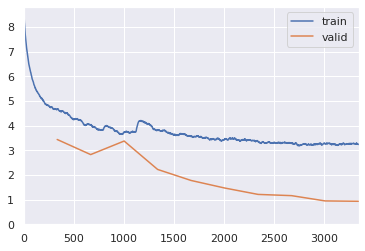

Better model found at epoch 1 with valid_loss value: 2.8286118507385254.
Better model found at epoch 3 with valid_loss value: 2.226017475128174.
Better model found at epoch 4 with valid_loss value: 1.778168797492981.
Better model found at epoch 5 with valid_loss value: 1.4729323387145996.
Better model found at epoch 6 with valid_loss value: 1.212854266166687.
Better model found at epoch 7 with valid_loss value: 1.1626179218292236.
Better model found at epoch 8 with valid_loss value: 0.9488264322280884.
Better model found at epoch 9 with valid_loss value: 0.9338884353637695.


In [ ]:
# set learning rate and fit base model
lr = 1e-2
learn.fit_one_cycle(10, lr)

In [ ]:
# save model parameters
learn.load('bestmodel')
learn.save('cnn_model-10_epoch', return_path=True)

PosixPath('/content/drive/My Drive/PlantVillage-Dataset/raw/color/models/cnn_model-10_epoch.pth')

In [ ]:
learn = learn.load('cnn_model-10_epoch')

In [ ]:
iterp = ClassificationInterpretation.from_learner(learn)

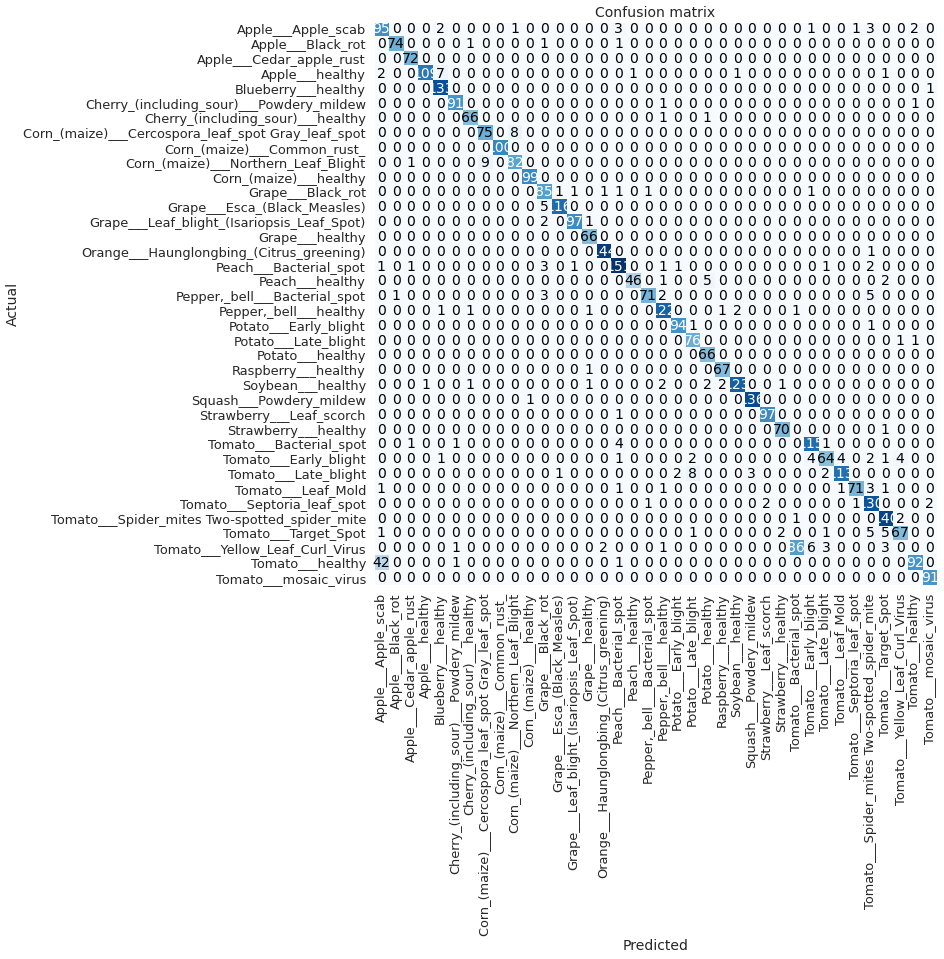

In [ ]:
# plot confusion matrix
iterp.plot_confusion_matrix(figsize=(16,16), dpi=60)

In [ ]:
from sklearn.metrics import fbeta_score, precision_score, recall_score

In [ ]:
# Calculate validation error metrics for base model

output, target = learn.TTA(ds_type=DatasetType.Valid)
pred_prob, pred_class = output.max(1) 

accuracy = top_k_accuracy(output, target, 1)
top_3_accuracy = top_k_accuracy(output, target, 3)
precision = precision_score(y_pred=pred_class, y_true=target, 
                                  average='weighted')
recall = recall_score(y_pred=pred_class, y_true=target, 
                                  average='weighted')
fbeta = fbeta_score(y_pred=pred_class, y_true=target, 
                                  beta=1, average='weighted')
print("Validation Accuracy: {}".format(accuracy))
print("Validation Top-3 Accuracy: {}".format(top_3_accuracy))
print("Validation Precision: {}".format(precision))
print("Validation Recall: {}".format(recall))
print("Validation F1 Score: {}".format(fbeta)) 

Validation Accuracy: 0.9277359247207642
Validation Top-3 Accuracy: 0.9932414889335632
Validation Precision: 0.9329392970072663
Validation Recall: 0.9277358981024175
Validation F1 Score: 0.9277079530846685


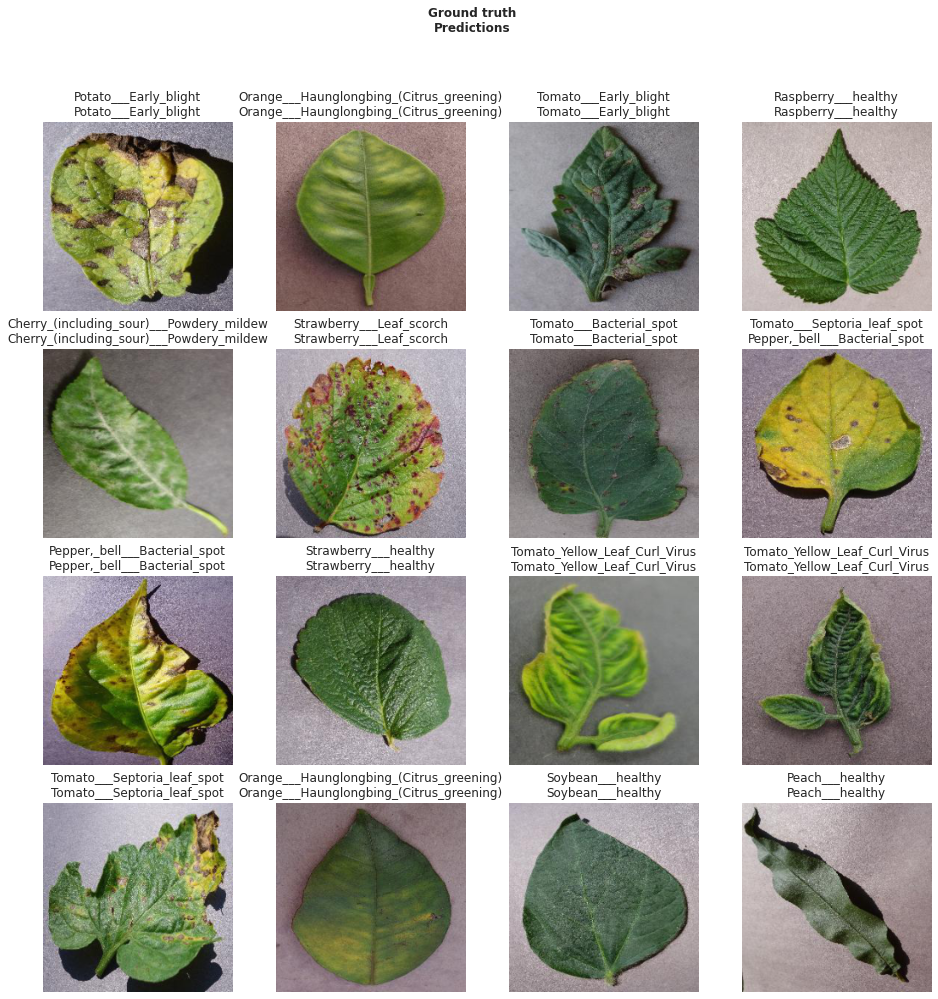

In [ ]:
# compare predicted results with ground truth
learn.show_results(ds_type=DatasetType.Valid, rows=4)

## Transfer Learning

In [ ]:
import pretrainedmodels
from pretrainedmodels import *
print(pretrainedmodels.model_names)


['fbresnet152', 'bninception', 'resnext101_32x4d', 'resnext101_64x4d', 'inceptionv4', 'inceptionresnetv2', 'alexnet', 'densenet121', 'densenet169', 'densenet201', 'densenet161', 'resnet18', 'resnet34', 'resnet50', 'resnet101', 'resnet152', 'inceptionv3', 'squeezenet1_0', 'squeezenet1_1', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn', 'vgg19_bn', 'vgg19', 'nasnetamobile', 'nasnetalarge', 'dpn68', 'dpn68b', 'dpn92', 'dpn98', 'dpn131', 'dpn107', 'xception', 'senet154', 'se_resnet50', 'se_resnet101', 'se_resnet152', 'se_resnext50_32x4d', 'se_resnext101_32x4d', 'cafferesnet101', 'pnasnet5large', 'polynet']


In [ ]:
def model_resnext50(pretrained=True,**kwargs):
    return se_resnext50_32x4d(num_classes=1000,pretrained='imagenet')

def model_inception_v3(pretrained=True,**kwargs):
    return inceptionv3(num_classes=1000,pretrained='imagenet')

### ResNext50

In [ ]:
# Create ResNext50
learner = cnn_learner(data, base_arch=model_resnext50,
                      cut=-2, 
                      metrics=[error_rate,accuracy],
                      path=path,
                      model_dir='models',
                      callback_fns=ShowGraph)
# Add callbacks
callbacks = [EarlyStoppingCallback(learner, min_delta=1e-5, patience=3),
             SaveModelCallback(learner)]

learner.callbacks = callbacks

Better model found at epoch 0 with valid_loss value: 0.2965693771839142.


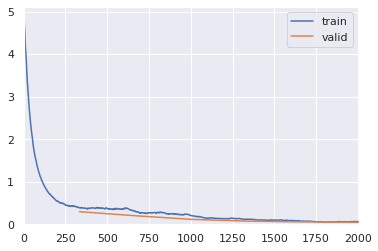

Better model found at epoch 1 with valid_loss value: 0.20130427181720734.
Better model found at epoch 2 with valid_loss value: 0.11655669659376144.
Better model found at epoch 3 with valid_loss value: 0.07497904449701309.
Better model found at epoch 4 with valid_loss value: 0.057210005819797516.
Better model found at epoch 5 with valid_loss value: 0.04823824390769005.


In [ ]:
# set learning rate and fit
lr = 1e-2
learner.fit_one_cycle(6, lr)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 6.31E-06


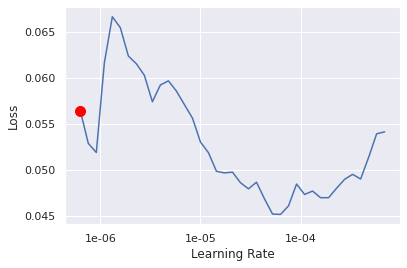

In [ ]:
# unfreeze pretrained layers
learner.unfreeze()

# find optimal learning rate
learner.lr_find()
learner.recorder.plot(suggestion=True)

Better model found at epoch 0 with valid_loss value: 0.04871416836977005.


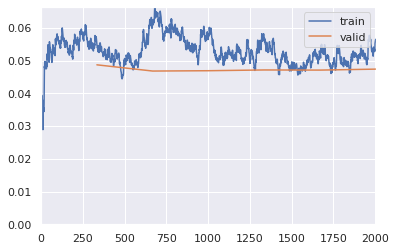

Better model found at epoch 1 with valid_loss value: 0.04681405425071716.
Epoch 5: early stopping


PosixPath('/content/drive/My Drive/PlantVillage-Dataset/raw/color/models/model_resnext50_32x4d.pth')

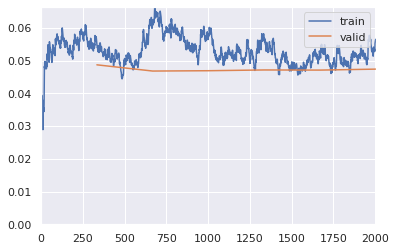

In [ ]:
# set differential learning rate
learner.fit_one_cycle(6, max_lr=slice(1e-6, 1e-4))

# load best model and save
learner = learner.load('bestmodel')
learner.save('model_resnext50_32x4d', return_path=True)

In [ ]:
learner = learner.load('model_resnext50_32x4d')

In [ ]:
iterp = ClassificationInterpretation.from_learner(learner)

In [ ]:
# check most confused predictions
iterp.most_confused(min_val=2)

[('Tomato___healthy', 'Apple___Apple_scab', 45),
 ('Apple___Apple_scab', 'Tomato___healthy', 8),
 ('Peach___healthy', 'Potato___healthy', 7),
 ('Corn_(maize)___Northern_Leaf_Blight',
  'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
  3),
 ('Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
  'Corn_(maize)___Northern_Leaf_Blight',
  2),
 ('Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Bacterial_spot', 2)]

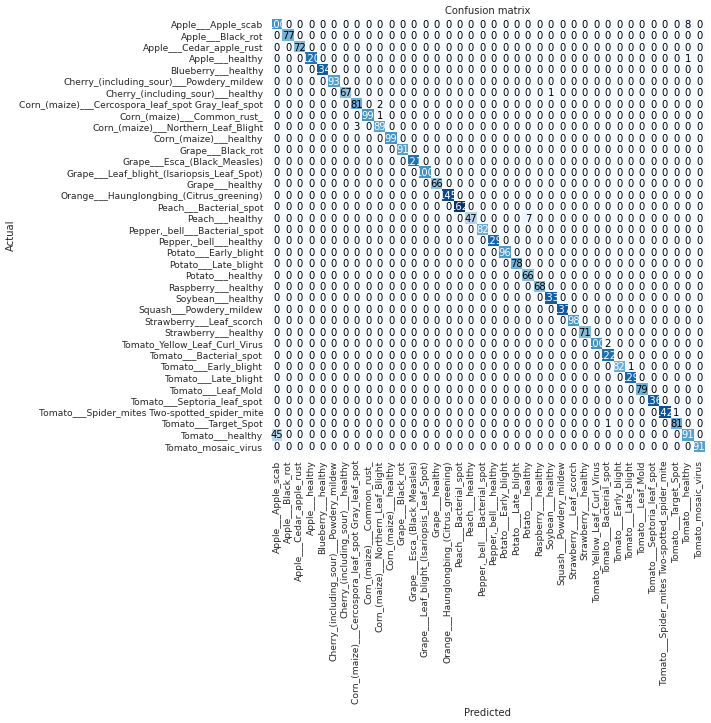

In [ ]:
iterp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [ ]:
# Calculate validation error metrics for ResNext50

output, target = learner.TTA(ds_type=DatasetType.Valid)
pred_prob, pred_class = output.max(1)

accuracy = top_k_accuracy(output, target, 1)
top_3_accuracy = top_k_accuracy(output, target, 3)
precision = precision_score(y_pred=pred_class, y_true=target, 
                                  average='weighted')
recall = recall_score(y_pred=pred_class, y_true=target, 
                                  average='weighted')
fbeta = fbeta_score(y_pred=pred_class, y_true=target, 
                                  beta=1, average='weighted')
print("Validation Accuracy: {}".format(accuracy))
print("Validation Top-3 Accuracy: {}".format(top_3_accuracy))
print("Validation Precision: {}".format(precision))
print("Validation Recall: {}".format(recall))
print("Validation F1 Score: {}".format(fbeta)) 

Validation Accuracy: 0.9823238849639893
Validation Top-3 Accuracy: 1.0
Validation Precision: 0.9850287279377584
Validation Recall: 0.9823238887444762
Validation F1 Score: 0.9822196150966904


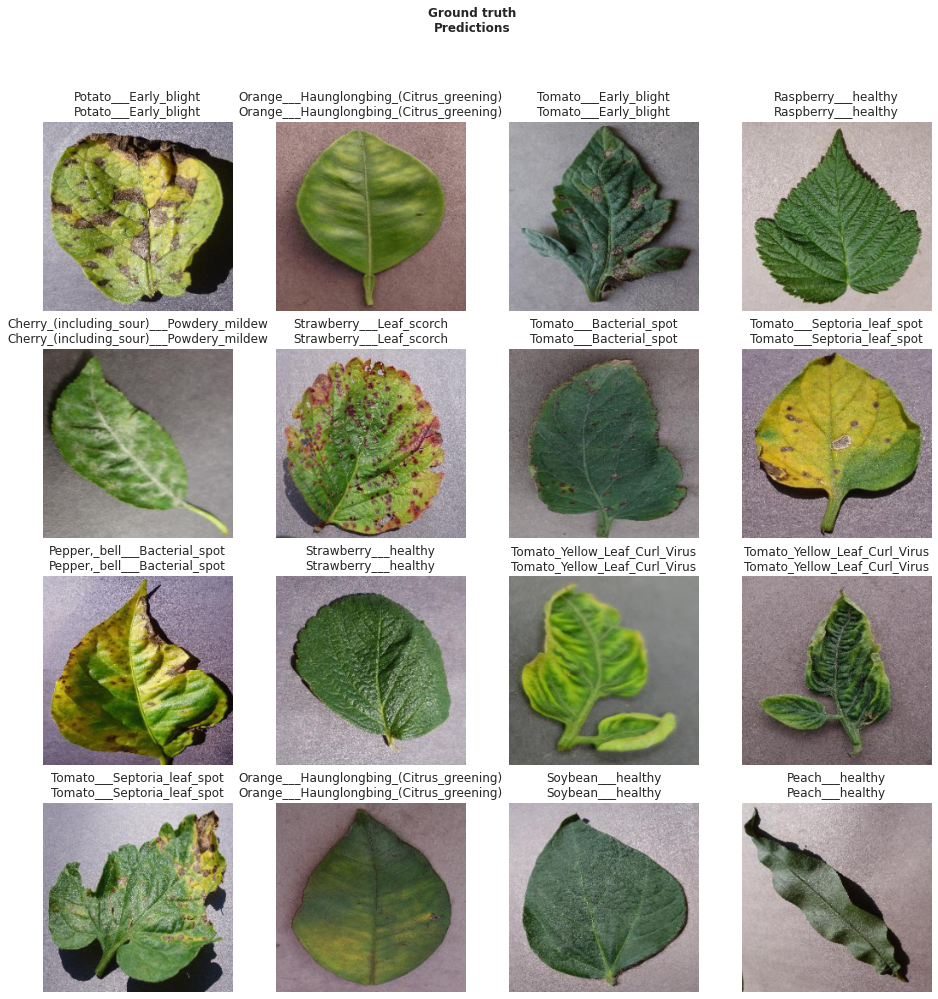

In [ ]:
# compare predicted and ground truth images 
learner.show_results(ds_type=DatasetType.Valid, rows=4)

In [ ]:
# Get output predictions and original targets
out, _ = learner.TTA(ds_type=DatasetType.Test)

### InceptionV3

In [ ]:
# Create InceptionV3
learner = cnn_learner(data, base_arch=models.vgg16_bn,
                      cut=-2,
                      pretrained=True, 
                      metrics=[error_rate,accuracy],
                      path=path,
                      model_dir='models',
                      callback_fns=ShowGraph)
# add early stopping 
callbacks = [EarlyStoppingCallback(learner, min_delta=1e-5, patience=3),
             SaveModelCallback(learner)]

learner.callbacks = callbacks

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


Better model found at epoch 0 with valid_loss value: 0.30740198493003845.


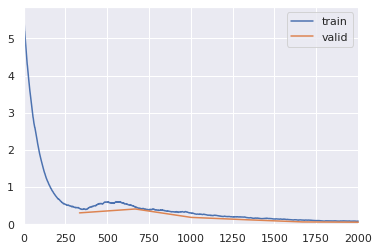

Better model found at epoch 2 with valid_loss value: 0.18607951700687408.
Better model found at epoch 3 with valid_loss value: 0.12210004776716232.
Better model found at epoch 4 with valid_loss value: 0.0636649802327156.
Better model found at epoch 5 with valid_loss value: 0.05623374134302139.


In [ ]:
# set learning rate and fit model 
lr = 1e-2
learner.fit_one_cycle(6, lr)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.32E-06
Min loss divided by 10: 8.32E-07


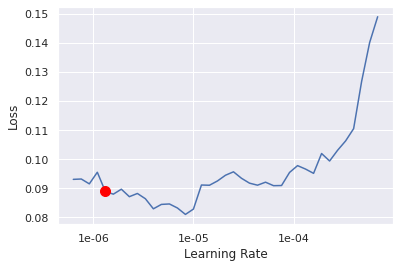

In [ ]:
# unfreeze pretrained layers
learner.unfreeze()

# find optimal learning rate
learner.lr_find()
learner.recorder.plot(suggestion=True)

Better model found at epoch 0 with valid_loss value: 0.055137164890766144.


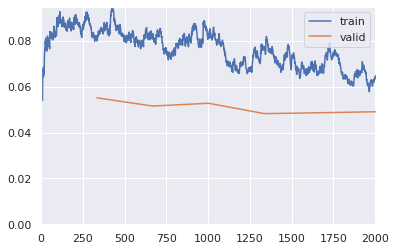

Better model found at epoch 1 with valid_loss value: 0.05155312642455101.
Better model found at epoch 3 with valid_loss value: 0.04825294017791748.


PosixPath('/content/drive/My Drive/PlantVillage-Dataset/raw/color/models/model_vgg-16.pth')

In [ ]:
# set differential learning rate
learner.fit_one_cycle(6, max_lr=slice(1e-6, 1e-4))


learner = learner.load('bestmodel')
learner.save('model_vgg-16', return_path=True)

In [ ]:
learner = learner.load('model_vgg-16')

In [ ]:
interp = ClassificationInterpretation.from_learner(learner)

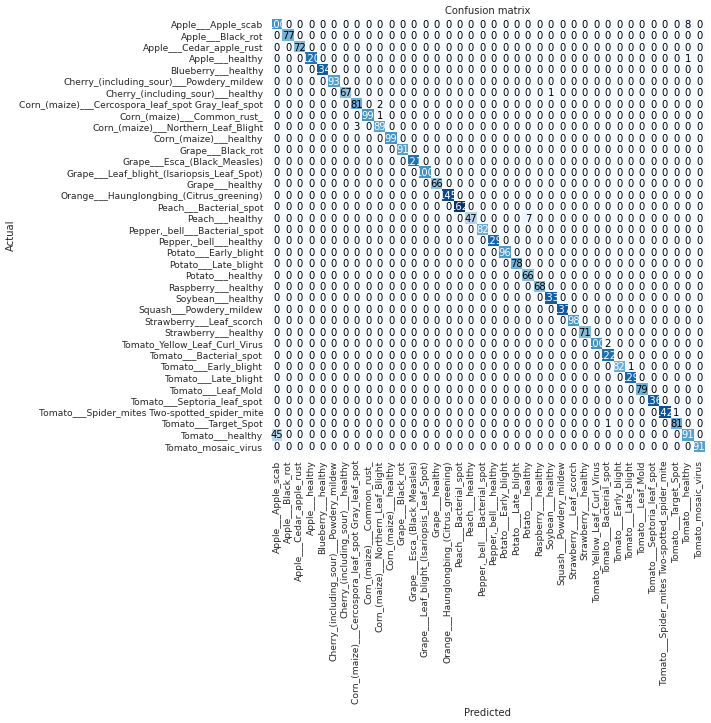

In [ ]:
iterp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [ ]:
iterp.most_confused(min_val=2)

[('Tomato___healthy', 'Apple___Apple_scab', 45),
 ('Apple___Apple_scab', 'Tomato___healthy', 8),
 ('Peach___healthy', 'Potato___healthy', 7),
 ('Corn_(maize)___Northern_Leaf_Blight',
  'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
  3),
 ('Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
  'Corn_(maize)___Northern_Leaf_Blight',
  2),
 ('Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Bacterial_spot', 2)]

In [ ]:
output, target = learner.TTA(ds_type=DatasetType.Valid)
pred_prob, pred_class = output.max(1)

In [ ]:
# Calculate validation error metrics
accuracy = top_k_accuracy(output, target, 1)
top_3_accuracy = top_k_accuracy(output, target, 3)
precision = precision_score(y_pred=pred_class, y_true=target, 
                                  average='weighted')
recall = recall_score(y_pred=pred_class, y_true=target, 
                                  average='weighted')
fbeta = fbeta_score(y_pred=pred_class, y_true=target, 
                                  beta=1, average='weighted')
print("Validation Accuracy: {}".format(accuracy))
print("Validation Top-3 Accuracy: {}".format(top_3_accuracy))
print("Validation Precision: {}".format(precision))
print("Validation Recall: {}".format(recall))
print("Validation F1 Score: {}".format(fbeta)) 

Validation Accuracy: 0.9820639491081238
Validation Top-3 Accuracy: 0.999480128288269
Validation Precision: 0.9853480276278811
Validation Recall: 0.9820639459318949
Validation F1 Score: 0.9819217048524665


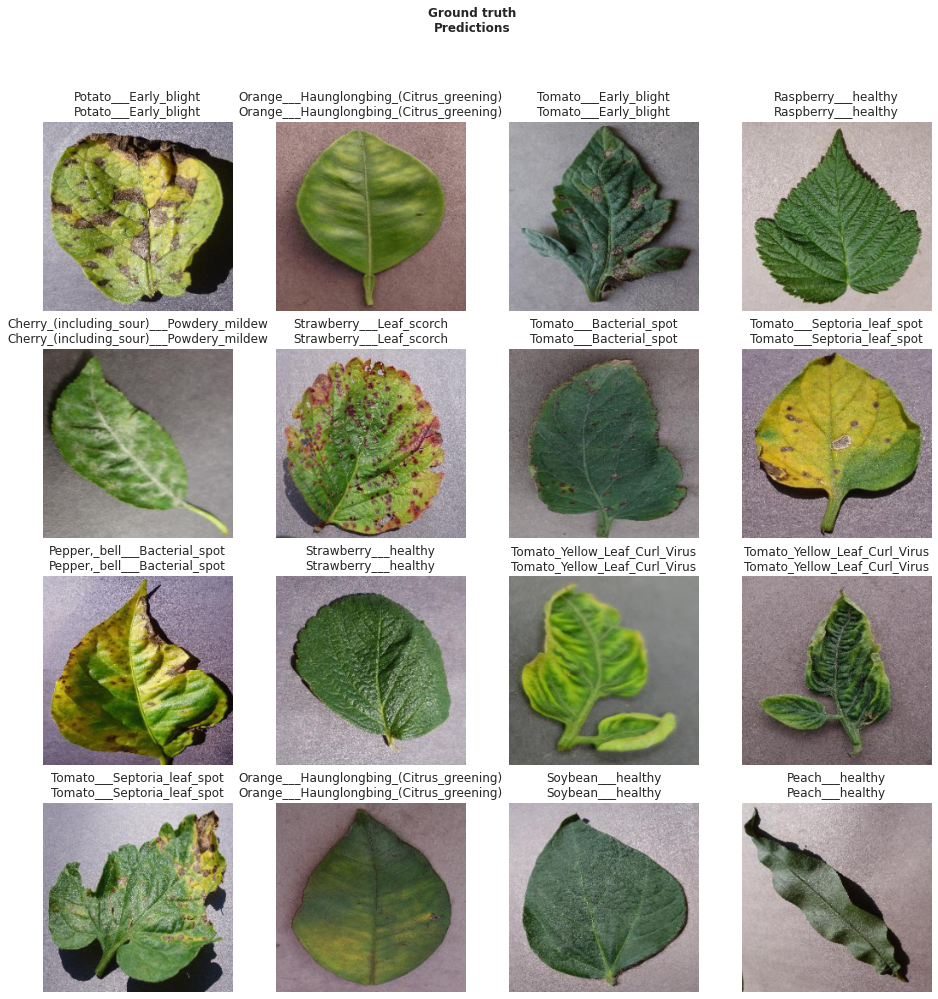

In [ ]:
learner.show_results(ds_type=DatasetType.Valid, rows=4)